In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from datetime import datetime, timedelta
from mlxtend.frequent_patterns import apriori, association_rules 
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [56]:
# Primera actividad: implementar esta librería (la descripción se revisa más adelante)
import web_usage as wu

# Objetivo

En esta práctica explorarás la identificación de sesiones de usuario a partir del registro de actividades en un sitio web. 


# Datos

Puedes acceder a los datos que se utilizarán en esta práctica a partir del siguiente enlace:

https://www.kaggle.com/datasets/shawon10/web-log-dataset

In [57]:
dat = pd.read_csv("weblog.csv")
dat.head(n = 20)

,IP,Time,URL,Staus
0,10.128.2.1,[29/Nov/2017:06:58:55,GET /login.php HTTP/1.1,200
1,10.128.2.1,[29/Nov/2017:06:59:02,POST /process.php HTTP/1.1,302
2,10.128.2.1,[29/Nov/2017:06:59:03,GET /home.php HTTP/1.1,200
3,10.131.2.1,[29/Nov/2017:06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200
4,10.130.2.1,[29/Nov/2017:06:59:06,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200
5,10.130.2.1,[29/Nov/2017:06:59:19,GET /profile.php?user=bala HTTP/1.1,200
6,10.128.2.1,[29/Nov/2017:06:59:19,GET /js/jquery.min.js HTTP/1.1,200
7,10.131.2.1,[29/Nov/2017:06:59:19,GET /js/chart.min.js HTTP/1.1,200
8,10.131.2.1,[29/Nov/2017:06:59:30,GET /edit.php?name=bala HTTP/1.1,200
9,10.131.2.1,[29/Nov/2017:06:59:37,GET /logout.php HTTP/1.1,302


In [58]:
len(dat)

16007

# Estrategias

Existen varias estrategias para identificar sesiones de usuario, las más empleadas se basan en heurísticas definidas a partir del tiempo transcurrido entre la apertura de dos páginas consecutivas, el cual no debe exceder de algún umbral para que la secuencia de páginas se asocie a una misma sesión. 

Puedes encontrar mayor información sobre este proceso en la siguiente página:

https://www.researchgate.net/publication/2534306_Data_Preparation_for_Mining_World_Wide_Web_Browsing_Patterns


## Preproceso (limpieza y transformación)


Iniciamos eliminando el corchete izquierdo de la columna *Tiempo*, el cual siempre aparece como el primer caracter:

In [59]:
# dat = wu.elimina_corchete(dat)
dat = wu.elimina_corchete(dat)
dat.head()

,IP,Time,URL,Staus
0,10.128.2.1,29/Nov/2017:06:58:55,GET /login.php HTTP/1.1,200
1,10.128.2.1,29/Nov/2017:06:59:02,POST /process.php HTTP/1.1,302
2,10.128.2.1,29/Nov/2017:06:59:03,GET /home.php HTTP/1.1,200
3,10.131.2.1,29/Nov/2017:06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200
4,10.130.2.1,29/Nov/2017:06:59:06,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200


### Filtrado de fechas

Tenemos que depurar la información de la columna fecha. Para empezar, no todos los registros contienen una fecha válida.

Observa por ejemplo las siguientes filas:


In [60]:
dat.iloc[1770:1780]

,IP,Time,URL,Staus
1770,10.131.2.1,30/Nov/2017:15:13:34,GET /js/chart.min.js HTTP/1.1,200
1771,10.131.0.1,30/Nov/2017:15:14:33,GET /contestproblem.php?name=RUET%20OJ%20Serve...,200
1772,10.131.2.1,30/Nov/2017:15:14:41,GET /contestsubmit.php?id=42 HTTP/1.1,200
1773,chmod:,cannot,'a.out':,No
1774,chmod:,cannot,'error.txt':,No
1775,rm:,cannot,'*.o':,No
1776,rm:,cannot,'a.out':,No
1777,10.131.2.1,30/Nov/2017:15:14:47,POST /pcompile.php HTTP/1.1,200
1778,10.131.0.1,30/Nov/2017:15:14:48,GET /details.php?id=41 HTTP/1.1,200
1779,10.131.2.1,30/Nov/2017:15:14:51,POST /contestsubmission.php HTTP/1.1,200


Filtramos las filas que tienen el patrón de fecha y tiempo:

In [61]:
dat = wu.filtra_fecha_hora(dat)
len(dat)

15789

In [62]:
dat.iloc[1770:1780]

,IP,Time,URL,Staus
1770,10.131.2.1,30/Nov/2017:15:13:34,GET /js/chart.min.js HTTP/1.1,200
1771,10.131.0.1,30/Nov/2017:15:14:33,GET /contestproblem.php?name=RUET%20OJ%20Serve...,200
1772,10.131.2.1,30/Nov/2017:15:14:41,GET /contestsubmit.php?id=42 HTTP/1.1,200
1777,10.131.2.1,30/Nov/2017:15:14:47,POST /pcompile.php HTTP/1.1,200
1778,10.131.0.1,30/Nov/2017:15:14:48,GET /details.php?id=41 HTTP/1.1,200
1779,10.131.2.1,30/Nov/2017:15:14:51,POST /contestsubmission.php HTTP/1.1,200
1780,10.131.2.1,30/Nov/2017:15:15:00,GET /details.php?name=Research%20Items&cod=16 ...,200
1781,10.128.2.1,30/Nov/2017:15:15:04,GET /contestsubmit.php?id=42 HTTP/1.1,200
1786,10.128.2.1,30/Nov/2017:15:15:12,POST /pcompile.php HTTP/1.1,200
1787,10.130.2.1,30/Nov/2017:15:15:18,POST /contestsubmission.php HTTP/1.1,200


### Separación fecha-tiempo

Observa que la columna *Time* contiene la información de la fecha y el tiempo **unidos** y es necesario separarlos.

In [63]:
dat = wu.separa_fecha_hora(dat) #genera la columna date_time
dat.head()

,IP,Time,URL,Staus,date_time
0,10.128.2.1,29/Nov/2017:06:58:55,GET /login.php HTTP/1.1,200,2017-11-29 06:58:55
1,10.128.2.1,29/Nov/2017:06:59:02,POST /process.php HTTP/1.1,302,2017-11-29 06:59:02
2,10.128.2.1,29/Nov/2017:06:59:03,GET /home.php HTTP/1.1,200,2017-11-29 06:59:03
3,10.131.2.1,29/Nov/2017:06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200,2017-11-29 06:59:04
4,10.130.2.1,29/Nov/2017:06:59:06,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200,2017-11-29 06:59:06


Obssrva que la columna *date_time* es del tipo "datetime".

In [64]:
dat["date_time"]

0       2017-11-29 06:58:55
1       2017-11-29 06:59:02
2       2017-11-29 06:59:03
3       2017-11-29 06:59:04
4       2017-11-29 06:59:06
                ...        
16002   2018-03-02 15:47:12
16003   2018-03-02 15:47:23
16004   2018-03-02 15:47:32
16005   2018-03-02 15:47:35
16006   2018-03-02 15:47:46
Name: date_time, Length: 15789, dtype: datetime64[ns]

## Ordenamiento

Para facilitar la identificación de sesiones de usuario, ordenamos las filas de acuerdo a la IP y al timestamp de cada evento. ¿Puedes identificar las sesiones de usuario?

In [65]:
dat = wu.ordena(dat)
dat.head(n = 20)

,IP,Time,URL,Staus,date_time
4336,10.128.2.1,08/Nov/2017:01:36:22,GET / HTTP/1.1,302,2017-11-08 01:36:22
5454,10.128.2.1,08/Nov/2017:01:36:22,GET / HTTP/1.1,302,2017-11-08 01:36:22
4340,10.128.2.1,08/Nov/2017:05:01:22,GET / HTTP/1.1,302,2017-11-08 05:01:22
5458,10.128.2.1,08/Nov/2017:05:01:22,GET / HTTP/1.1,302,2017-11-08 05:01:22
4349,10.128.2.1,08/Nov/2017:08:32:30,GET /login.php HTTP/1.1,200,2017-11-08 08:32:30
5467,10.128.2.1,08/Nov/2017:08:32:30,GET /login.php HTTP/1.1,200,2017-11-08 08:32:30
4353,10.128.2.1,08/Nov/2017:11:33:01,GET /login.php HTTP/1.1,200,2017-11-08 11:33:01
5471,10.128.2.1,08/Nov/2017:11:33:01,GET /login.php HTTP/1.1,200,2017-11-08 11:33:01
4361,10.128.2.1,08/Nov/2017:17:28:10,GET /login.php HTTP/1.1,200,2017-11-08 17:28:10
5479,10.128.2.1,08/Nov/2017:17:28:10,GET /login.php HTTP/1.1,200,2017-11-08 17:28:10


En esta sección de la tabla puedes identificar una sesión de usuario bastante larga.

In [66]:
dat.loc[dat["IP"]=="10.128.2.1"][50:100]

,IP,Time,URL,Staus,date_time
4507,10.128.2.1,10/Nov/2017:03:18:05,GET / HTTP/1.1,302,2017-11-10 03:18:05
5625,10.128.2.1,10/Nov/2017:03:18:05,GET / HTTP/1.1,302,2017-11-10 03:18:05
4516,10.128.2.1,10/Nov/2017:07:46:54,GET / HTTP/1.1,302,2017-11-10 07:46:54
5634,10.128.2.1,10/Nov/2017:07:46:54,GET / HTTP/1.1,302,2017-11-10 07:46:54
4520,10.128.2.1,10/Nov/2017:15:55:45,GET / HTTP/1.1,302,2017-11-10 15:55:45
5638,10.128.2.1,10/Nov/2017:15:55:45,GET / HTTP/1.1,302,2017-11-10 15:55:45
4521,10.128.2.1,10/Nov/2017:15:55:46,GET /robots.txt HTTP/1.1,404,2017-11-10 15:55:46
5639,10.128.2.1,10/Nov/2017:15:55:46,GET /robots.txt HTTP/1.1,404,2017-11-10 15:55:46
4586,10.128.2.1,11/Nov/2017:19:16:16,GET /contestproblem.php?name=RUET%20OJ%20TLE%2...,200,2017-11-11 19:16:16
5704,10.128.2.1,11/Nov/2017:19:16:16,GET /contestproblem.php?name=RUET%20OJ%20TLE%2...,200,2017-11-11 19:16:16


## Sesionización

In [67]:
dat = wu.sesionizacion(dat, dt=10)
dat.loc[dat["IP"]=="10.128.2.1"][50:100]

,IP,Time,URL,Staus,date_time,session
4507,10.128.2.1,10/Nov/2017:03:18:05,GET / HTTP/1.1,302,2017-11-10 03:18:05,19
5625,10.128.2.1,10/Nov/2017:03:18:05,GET / HTTP/1.1,302,2017-11-10 03:18:05,19
4516,10.128.2.1,10/Nov/2017:07:46:54,GET / HTTP/1.1,302,2017-11-10 07:46:54,20
5634,10.128.2.1,10/Nov/2017:07:46:54,GET / HTTP/1.1,302,2017-11-10 07:46:54,20
4520,10.128.2.1,10/Nov/2017:15:55:45,GET / HTTP/1.1,302,2017-11-10 15:55:45,21
5638,10.128.2.1,10/Nov/2017:15:55:45,GET / HTTP/1.1,302,2017-11-10 15:55:45,21
4521,10.128.2.1,10/Nov/2017:15:55:46,GET /robots.txt HTTP/1.1,404,2017-11-10 15:55:46,21
5639,10.128.2.1,10/Nov/2017:15:55:46,GET /robots.txt HTTP/1.1,404,2017-11-10 15:55:46,21
4586,10.128.2.1,11/Nov/2017:19:16:16,GET /contestproblem.php?name=RUET%20OJ%20TLE%2...,200,2017-11-11 19:16:16,22
5704,10.128.2.1,11/Nov/2017:19:16:16,GET /contestproblem.php?name=RUET%20OJ%20TLE%2...,200,2017-11-11 19:16:16,22


## Recursos

Separamos los 3 elementos de la columna URL

In [68]:
splt_url = wu.separa_url(dat['URL'])
splt_url

,0,1,2
4336,GET,/,HTTP/1.1
5454,GET,/,HTTP/1.1
4340,GET,/,HTTP/1.1
5458,GET,/,HTTP/1.1
4349,GET,/login.php,HTTP/1.1
...,...,...,...
4309,GET,/contest.php,HTTP/1.1
4311,GET,/contest.php,HTTP/1.1
4312,GET,/contestproblem.php?name=RUET%20OJ%20TLE%20Tes...,HTTP/1.1
4316,GET,/compiler.php,HTTP/1.1


In [69]:
dat["resource"] = splt_url[1]
dat.head()

,IP,Time,URL,Staus,date_time,session,resource
4336,10.128.2.1,08/Nov/2017:01:36:22,GET / HTTP/1.1,302,2017-11-08 01:36:22,1,/
5454,10.128.2.1,08/Nov/2017:01:36:22,GET / HTTP/1.1,302,2017-11-08 01:36:22,1,/
4340,10.128.2.1,08/Nov/2017:05:01:22,GET / HTTP/1.1,302,2017-11-08 05:01:22,2,/
5458,10.128.2.1,08/Nov/2017:05:01:22,GET / HTTP/1.1,302,2017-11-08 05:01:22,2,/
4349,10.128.2.1,08/Nov/2017:08:32:30,GET /login.php HTTP/1.1,200,2017-11-08 08:32:30,3,/login.php


## Parámetros



In [70]:
#wu.limpia_recurso(dat["resource"])
dat["resource"] = wu.limpia_recurso(dat["resource"])
dat.head()

,IP,Time,URL,Staus,date_time,session,resource
4336,10.128.2.1,08/Nov/2017:01:36:22,GET / HTTP/1.1,302,2017-11-08 01:36:22,1,/
5454,10.128.2.1,08/Nov/2017:01:36:22,GET / HTTP/1.1,302,2017-11-08 01:36:22,1,/
4340,10.128.2.1,08/Nov/2017:05:01:22,GET / HTTP/1.1,302,2017-11-08 05:01:22,2,/
5458,10.128.2.1,08/Nov/2017:05:01:22,GET / HTTP/1.1,302,2017-11-08 05:01:22,2,/
4349,10.128.2.1,08/Nov/2017:08:32:30,GET /login.php HTTP/1.1,200,2017-11-08 08:32:30,3,/login.php


In [71]:
len(pd.unique(dat["resource"]))

62

## <font color="red">Actividad</font>

1. Implementa las funciones necesarias para resolver la sesionización.
2. Construye una gráfica de barras en la que muestres la frecuencia de visitas de cada recurso, ordenados de forma descendente.
3. Considerando que cada sesión representa una canasta de compras, aplica el algoritmo apriori para dientificar los patrones de navegación más comunes. 
    * Explora diferentes valores para el soporte y la confianza de manera que los resultados sean informativos. 
    * Lista las reglas de navegación más representativas.   
    * Muestra los resultados usando gráficas adecuadas.
4. Construye la matriz *usuario-página* (binaria) que resuma la información del conjunto de datos.
5. Aplica algún algoritmo de clusterización para segmentar usuarios (sesiones de usuario). 
    * Proyecta los datos a un espacio de menor dimensión usando PCA (justifica la elección de la dimensionalidad del espacio sobre el cual vas a proyectar).
    * Utiliza algún criterio adecuado para definir el total de grupos.
    * Forma los grupos utilziando k-medias o clusterización jerárquica.
6. Aplica algún algoritmo de clusterización para segmentar recursos.
    * Proyecta los datos a un espacio de menor dimensión usando PCA (justifica la elección de la dimensionalidad del espacio sobre el cual vas a proyectar).
    * Utiliza algún criterio adecuado para definir el total de grupos.
    * Forma los grupos utilziando k-medias o clusterización jerárquica.
    


## 2- Construye una gráfica de barras en la que muestres la frecuencia de visitas de cada recurso, ordenados de forma descendente.

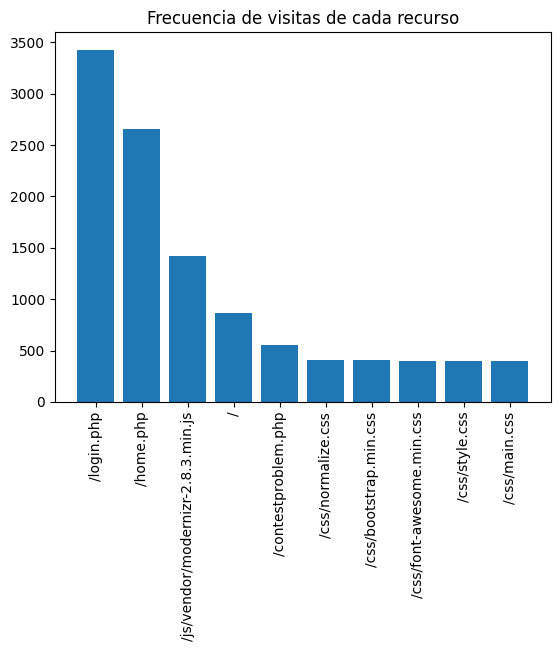

In [72]:
resource_counts = dat['resource'].value_counts().sort_values(ascending=False)

# Trazar la gráfica de barras
plt.bar(resource_counts.index[:10], resource_counts.values[:10])
plt.title('Frecuencia de visitas de cada recurso')
plt.xticks(rotation=90)
plt.show()

## 3. Considerando que cada sesión representa una canasta de compras, aplica el algoritmo apriori para dientificar los patrones de navegación más comunes. 
    * Explora diferentes valores para el soporte y la confianza de manera que los resultados sean informativos. 
    * Lista las reglas de navegación más representativas.   
    * Muestra los resultados usando gráficas adecuadas.

In [73]:
conv_list = dat.groupby('session')['resource'].apply(set).reset_index(name='Transactions')
T = conv_list.drop('session', axis=1)
T.head(n=10)

,Transactions
0,{/}
1,{/}
2,{/login.php}
3,{/login.php}
4,{/login.php}
5,{/robots.txt}
6,"{/, /login.php}"
7,"{/, /login.php}"
8,{/login.php}
9,{/login.php}


In [74]:
te = TransactionEncoder()
te_ary = te.fit(T['Transactions']).transform(T['Transactions']) # Transdormación a matriz
df_bool = pd.DataFrame(te_ary, columns=te.columns_)
df_bool.head(n = 10)

,/,//home.php,/action.php,/adminpanel.php,/allsubmission.php,/announcement.php,/archive.php,/bootstrap-3.3.7/js/bootstrap.js,/bootstrap-3.3.7/js/bootstrap.min.js,/compile.php,...,/profile.php,/robots.txt,/setcontest.php,/setcontestproblem.php,/setproblem.php,/showcode.php,/sign.php,/standings.php,/submit.php,/update.php
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
6,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [75]:
frequent_itemsets = apriori(df_bool, min_support=0.02, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.323404,(/)
1,0.037690,(/action.php)
2,0.048024,(/allsubmission.php)
3,0.089362,(/archive.php)
4,0.078419,(/bootstrap-3.3.7/js/bootstrap.js)
...,...,...
744,0.021884,"(/login.php, /fonts/fontawesome-webfont.woff2,..."
745,0.020669,"(/process.php, /login.php, /fonts/fontawesome-..."
746,0.022492,"(/process.php, /login.php, /js/vendor/jquery-1..."
747,0.022492,"(/process.php, /login.php, /fonts/fontawesome-..."


<Axes: >

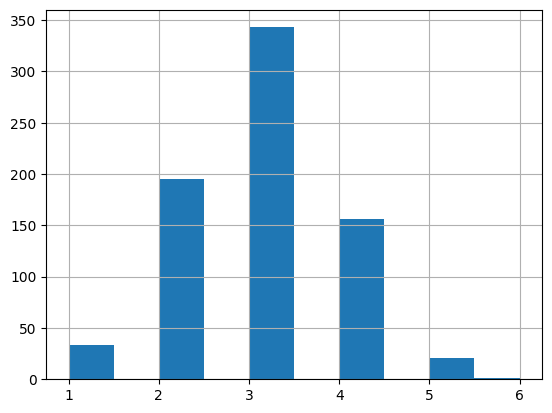

In [76]:
frequent_itemsets["n_items"] = frequent_itemsets["itemsets"].apply(lambda x: len(x))
frequent_itemsets["n_items"].hist()

In [77]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(/),(/login.php),0.323404,0.463222,0.165350,0.511278,1.103744,0.015542,1.098331,0.138920
1,(/action.php),(/bootstrap-3.3.7/js/bootstrap.js),0.037690,0.078419,0.020061,0.532258,6.787322,0.017105,1.970276,0.886062
2,(/action.php),(/home.php),0.037690,0.215805,0.027356,0.725806,3.363244,0.019222,2.860004,0.730189
3,(/action.php),(/login.php),0.037690,0.463222,0.034650,0.919355,1.984696,0.017192,6.656049,0.515577
4,(/action.php),(/process.php),0.037690,0.113678,0.027356,0.725806,6.384768,0.023071,3.232469,0.876409
...,...,...,...,...,...,...,...,...,...,...
1548,"(/home.php, /css/normalize.css, /fonts/fontawe...","(/js/vendor/jquery-1.12.0.min.js, /css/bootstr...",0.033435,0.048632,0.023100,0.690909,14.206818,0.021474,3.077955,0.961768
1549,"(/js/vendor/jquery-1.12.0.min.js, /css/normali...","(/home.php, /login.php, /fonts/fontawesome-web...",0.040122,0.054711,0.023100,0.575758,10.523569,0.020905,2.228181,0.942802
1550,"(/js/vendor/jquery-1.12.0.min.js, /css/bootstr...","(/css/normalize.css, /login.php, /fonts/fontaw...",0.031611,0.049240,0.023100,0.730769,14.840931,0.021544,3.531394,0.963062
1551,"(/js/vendor/jquery-1.12.0.min.js, /css/normali...","(/css/bootstrap.min.css, /login.php, /fonts/fo...",0.041945,0.062614,0.023100,0.550725,8.795554,0.020474,2.086440,0.925110


In [78]:
grap = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.9)
pd.DataFrame(grap)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(/action.php),(/login.php),0.037690,0.463222,0.034650,0.919355,1.984696,0.017192,6.656049,0.515577
1,"(/, /fonts/fontawesome-webfont.woff2)",(/login.php),0.031003,0.463222,0.027964,0.901961,1.947146,0.013602,5.475137,0.501991
2,"(/, /process.php)",(/login.php),0.032827,0.463222,0.029787,0.907407,1.958904,0.014581,5.797204,0.506125
3,"(/action.php, /bootstrap-3.3.7/js/bootstrap.js)",(/login.php),0.020061,0.463222,0.020061,1.000000,2.158793,0.010768,inf,0.547767
4,"(/action.php, /home.php)",(/login.php),0.027356,0.463222,0.026140,0.955556,2.062846,0.013468,12.077508,0.529724
...,...,...,...,...,...,...,...,...,...,...
150,"(/login.php, /fonts/fontawesome-webfont.woff2,...",(/js/vendor/jquery-1.12.0.min.js),0.025532,0.158055,0.023100,0.904762,5.724359,0.019065,8.840426,0.846932
151,"(/login.php, /js/vendor/jquery-1.12.0.min.js, ...",(/fonts/fontawesome-webfont.woff2),0.024924,0.114894,0.023100,0.926829,8.066847,0.020237,12.096454,0.898428
152,"(/fonts/fontawesome-webfont.woff2, /js/vendor/...",(/login.php),0.023100,0.463222,0.023100,1.000000,2.158793,0.012400,inf,0.549471
153,"(/css/bootstrap.min.css, /home.php, /css/norma...","(/js/vendor/jquery-1.12.0.min.js, /login.php)",0.025532,0.089362,0.023100,0.904762,10.124717,0.020819,9.561702,0.924845


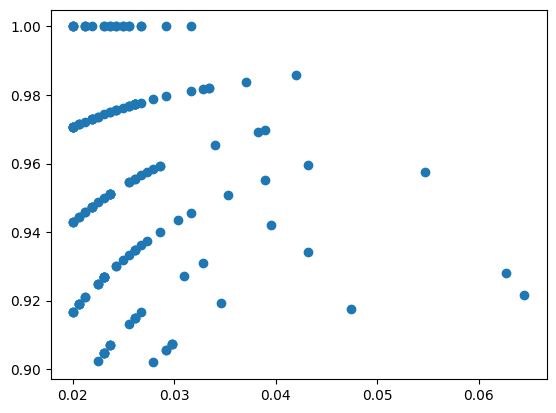

In [79]:
plt.scatter(grap['support'], grap['confidence'])
plt.show()

En el gráfico presentado, se puede observar que existe una relación inversa entre el soporte y la confianza. En otras palabras, a medida que el soporte disminuye, la confianza aumenta. Esta tendencia se puede verificar utilizando la tabla anterior, en la que se midió la confianza a partir del umbral del 90%.

## 4. Construye la matriz *usuario-página* (binaria) que resuma la información del conjunto de datos.

In [80]:
matriz_usuario_pagina = pd.pivot_table(dat, values='session', index=['URL'], columns=['IP'], aggfunc=lambda x: 1 if sum(x)>0 else 0, fill_value=0)
matriz_usuario_pagina


IP,10.128.2.1,10.129.2.1,10.130.2.1,10.131.0.1,10.131.2.1
URL,,,,,
GET / HTTP/1.0,0,0,0,0,1
GET / HTTP/1.1,1,1,1,1,1
GET //home.php HTTP/1.1,1,0,0,0,0
GET /action.php HTTP/1.0,1,0,0,1,0
GET /adminpanel.php HTTP/1.1,0,0,1,0,0
...,...,...,...,...,...
POST /pcompile.php HTTP/1.1,1,1,1,1,1
POST /process.php HTTP/1.0,0,0,1,0,0
POST /process.php HTTP/1.1,1,1,1,1,1


## 5- Aplica algún algoritmo de clusterización para segmentar usuarios (sesiones de usuario). 
    * Proyecta los datos a un espacio de menor dimensión usando PCA (justifica la elección de la dimensionalidad del espacio sobre el cual vas a proyectar).
    * Utiliza algún criterio adecuado para definir el total de grupos.
    * Forma los grupos utilziando k-medias o clusterización jerárquica.

In [81]:
scaler = StandardScaler()
matriz_usuario_pagina = scaler.fit_transform(matriz_usuario_pagina)
matriz_usuario_pagina

array([[-1.02076346, -0.87732375, -0.92729316, -1.06366671,  1.16397539],
       [ 0.97965889,  1.13983007,  1.07840761,  0.94014412,  1.16397539],
       [ 0.97965889, -0.87732375, -0.92729316, -1.06366671, -0.85912469],
       ...,
       [ 0.97965889,  1.13983007,  1.07840761,  0.94014412,  1.16397539],
       [-1.02076346, -0.87732375, -0.92729316, -1.06366671,  1.16397539],
       [ 0.97965889,  1.13983007, -0.92729316,  0.94014412, -0.85912469]])

In [82]:
pca = PCA(n_components=5)
pca.fit(matriz_usuario_pagina)

PCA(n_components=5)

Calcular la varianza explicacada por cada componente, para saber la cantidad de componentes a utilizar:

En este caso son cuatro ya que se busca el uso de la variaza en el alcance de **%70** a **%80** por lo tanto, podemos observar que la cantidad ideal al momento de rescatar datos seria de **4** componentes.

In [83]:
var_exp = pca.explained_variance_
np.cumsum(var_exp)/sum(var_exp)*100

array([ 39.53694796,  56.74740086,  72.983101  ,  87.18326937,
       100.        ])

In [84]:
pca = PCA(n_components=4)
pca.fit(matriz_usuario_pagina)

PCA(n_components=4)

In [85]:
x = pca.transform(matriz_usuario_pagina) 

### Clusterización 

Se utlizo el método del Codo, el número óptimo de clusters se elige en el punto donde la disminución de la inercia (Suma de las distancias al cuadrado de cada punto al centro de su cluster) se vuelve menos pronunciada

In [86]:
# lista para almacenar las inercias
inercias = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(x)
    inercias.append(kmeans.inertia_)

c:\Users\cyair\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\cyair\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\cyair\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\cyair\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

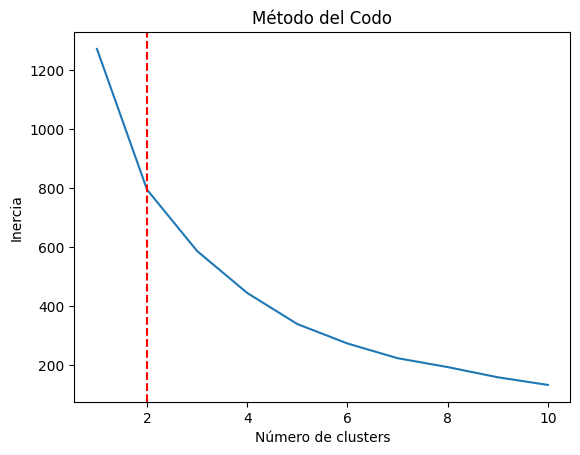

El número óptimo de clusters es: 2


In [87]:
# graficar la curva de la inercia
plt.plot(range(1, 11), inercias)
plt.title('Método del Codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')

# trazar una línea vertical en el punto del codo
diferencias = np.diff(inercias)
segundas_diferencias = np.diff(diferencias)
punto_codo = np.where(segundas_diferencias > 0)[0][0] + 2
plt.axvline(x=punto_codo, color='r', linestyle='--')
plt.show()

print('El número óptimo de clusters es:', punto_codo)

El numero de clusters a utilizar para la segmentacion es **2** dado a que el punto de codo es el primer valor en el que la curva de la inercia deja de disminuir de manera significativa al aumentar el número de clusters. Este valor corresponde al número óptimo de clusters para el conjunto de datos.

### Segmentación de usuarios

In [88]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(x)
labels = kmeans.predict(x)

c:\Users\cyair\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


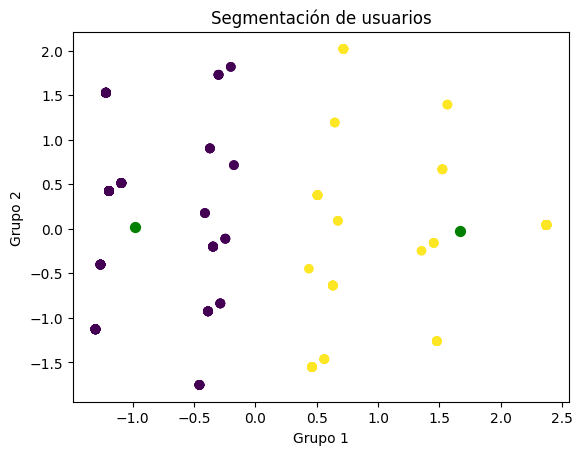

In [89]:
# Graficar grupos
plt.scatter(x[:, 0], x[:, 1], c=labels, cmap="viridis")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='green', s=50)
plt.title("Segmentación de usuarios")
plt.xlabel('Grupo 1')
plt.ylabel('Grupo 2')
plt.show()

La gráfica muestra cómo se dividen las sesiones de los usuarios en dos clusters, basados en las páginas a las que han accedido durante ciertos intervalos de tiempo. La evaluación se hace teniendo en cuenta las similitudes entre las sesiones de los usuarios y las páginas que han visitado. Cada sesión representa el tiempo que el usuario ha estado en la página antes de pasar a otra, lo que permite determinar patrones y similitudes entre los diferentes grupos de usuarios.

## 6. Aplica algún algoritmo de clusterización para segmentar recursos.
    * Proyecta los datos a un espacio de menor dimensión usando PCA (justifica la elección de la dimensionalidad del espacio sobre el cual vas a proyectar).
    * Utiliza algún criterio adecuado para definir el total de grupos.
    * Forma los grupos utilziando k-medias o clusterización jerárquica.

In [90]:
dat['resources'], _ = pd.factorize(dat['resource']) 
matrix = pd.pivot_table(dat, values="resources", index="URL", columns="IP", aggfunc=lambda x: 1 if sum(x)>0 else 0, fill_value=0)
matrix

IP,10.128.2.1,10.129.2.1,10.130.2.1,10.131.0.1,10.131.2.1
URL,,,,,
GET / HTTP/1.0,0,0,0,0,0
GET / HTTP/1.1,0,0,0,0,0
GET //home.php HTTP/1.1,1,0,0,0,0
GET /action.php HTTP/1.0,1,0,0,1,0
GET /adminpanel.php HTTP/1.1,0,0,1,0,0
...,...,...,...,...,...
POST /pcompile.php HTTP/1.1,1,1,1,1,1
POST /process.php HTTP/1.0,0,0,1,0,0
POST /process.php HTTP/1.1,1,1,1,1,1


In [91]:
# Normalizar matriz usuario-página
scaler = StandardScaler()
matrix = scaler.fit_transform(matrix)

In [92]:
pca2 = PCA(n_components=5)
pca2.fit(matrix)

PCA(n_components=5)

Calcular la varianza explicacada por cada componente, para saber la cantidad de componentes a utilizar:

En este caso son cuatro ya que se busca el uso de la variaza en el alcance de **%70** a **%80** por lo tanto, podemos observar que la cantidad ideal al momento de rescatar datos seria de **4** componentes.

In [93]:
var_exp = pca2.explained_variance_
np.cumsum(var_exp)/sum(var_exp)*100

array([ 39.70773614,  56.7941622 ,  73.0392916 ,  87.21351287,
       100.        ])

In [94]:
pca2 = PCA(n_components=4)
pca2.fit(matrix)

PCA(n_components=4)

In [95]:
x = pca.transform(matrix) 

### Clusterización 

Se utlizo el método del Codo, el número óptimo de clusters se elige en el punto donde la disminución de la inercia (Suma de las distancias al cuadrado de cada punto al centro de su cluster) se vuelve menos pronunciada

In [96]:
# lista para almacenar las varianzas inercias
inercias = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(x)
    inercias.append(kmeans.inertia_)

c:\Users\cyair\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\cyair\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\cyair\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\cyair\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

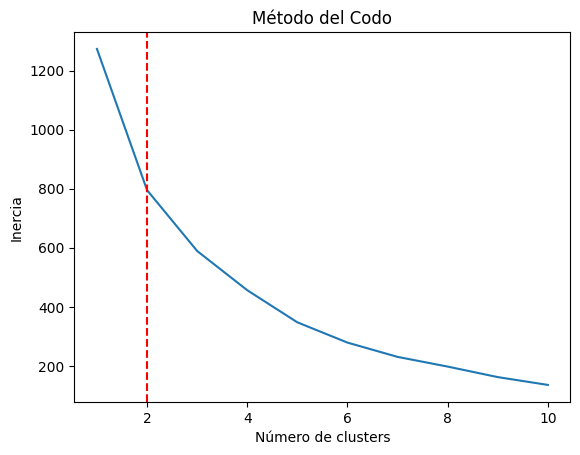

El número óptimo de clusters es: 2


In [97]:
# graficar la curva de la inercia
plt.plot(range(1, 11), inercias)
plt.title('Método del Codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')

# trazar una línea vertical en el punto del codo
diferencias = np.diff(inercias)
segundas_diferencias = np.diff(diferencias)
punto_codo = np.where(segundas_diferencias > 0)[0][0] + 2
plt.axvline(x=punto_codo, color='r', linestyle='--')
plt.show()

print('El número óptimo de clusters es:', punto_codo)

El numero de clusters a utilizar para la segmentacion es **2** dado a que el punto de codo es el primer valor en el que la curva de la inercia deja de disminuir de manera significativa al aumentar el número de clusters. Este valor corresponde al número óptimo de clusters para el conjunto de datos.

### Segmentación de recursos

In [98]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(x)
labels = kmeans.predict(x)

c:\Users\cyair\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


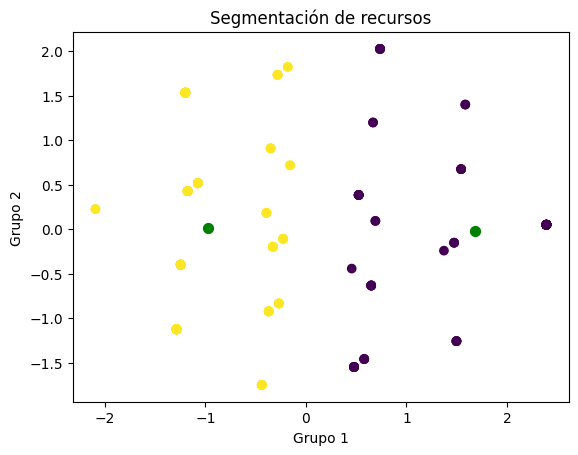

In [99]:
# Graficar grupos
plt.scatter(x[:, 0], x[:, 1], c=labels, cmap="viridis")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='green', s=50)
plt.title("Segmentación de recursos")
plt.xlabel('Grupo 1')
plt.ylabel('Grupo 2')
plt.show()

La grafica ilustra cómo se dividen los usuarios en dos grupos según ciertas características, utilizando dos componentes principales de los datos. Se puede notar que el comportamiento de las sesiones de usuario en el grupo 1 es diferente al de las sesiones en el grupo 0. La similitud en los recursos a los que los usuarios han accedido nos permite evaluar qué recursos han sido utilizados por los usuarios.